In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
%matplotlib inline
import pickle

In [2]:
from cUtils import *

In [3]:
dataPath = Path("../data")

### Load the Amat from real data

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [5]:
realPath = dataPath/"realmat.pkl"
if realPath.exists():
    with open(realPath, "rb") as f:
        real = pickle.load(f)
else:
    datF = list(dataPath.glob("*.mat"))[0]
    rawDat = loadmat(datF)
    dat = rawDat["DK_timecourse"]
    fs = 600
    q = 50
    nDat = mat2Tensor(dat, fs=fs, q=q)
    bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
    downrates = [1, 1]
    hs = [0.1, 0.1]
    T = 60
    _, dF, dT = nDat.Y.shape
    times = np.linspace(0, T, dT)
    freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
    Amat = GetAmatTorch(torch.tensor(nDat.Y.copy()), torch.tensor(nDat.X.copy()), times, freqs, downrates, hs)
    
    res = np.linalg.eig(Amat)
    absEigVs = np.abs(res[0])
    # Sort the eigvs and vectors such that the vals is in order
    sortIdx = np.argsort(absEigVs)[::-1]
    lams = res[0][sortIdx]
    U = res[1][:, sortIdx]
    
    real = edict()
    real["Amat"] = Amat
    real["U"] = U
    real["eigVs"] = lams
    real["X"] = nDat.X
    real["Y"] = nDat.Y
    
    with open(realPath, "wb") as f:
        pickle.dump(real, f)

In [6]:
def GenCVec(nR, eigInd):
    imgPart = np.random.randint(1, 10, nR)
    imgPart[eigInd==False] = 0
    imgPartSub = imgPart[eigInd]
    imgPartSub[1::2] = - imgPartSub[0::2]
    imgPart[eigInd] = imgPartSub
    
    realPart = np.random.randint(1, 10, nR)
    realPartSub = realPart[eigInd]
    realPartSub[1::2] = realPartSub[0::2]
    realPart[eigInd] = realPartSub
    
    cVec = realPart.astype(np.complex)
    cVec.imag = imgPart
    return cVec

In [7]:
def GenCVecs(nR, eigInd, num):
    Vecs = []
    for i in range(num):
        Vecs.append(GenCVec(nR, eigInd))
    return np.array(Vecs).T

In [8]:
def GenFVecs(nR, eigInd, ChgsF):
    num = len(ChgsF) - 1
    cVecs = GenCVecs(nR, eigInd, num)
    numSegs = np.diff(ChgsF)
    
    fVecsList = []
    for idx, numSeg in enumerate(numSegs):
        fVecsList = fVecsList + list(cVecs[:, idx]) * numSeg
    fVecs = np.array(fVecsList)
    return fVecs.reshape(-1, nR).T
    

In [9]:
dF = 5
dT = 200
nR = 6
ChgsFreq = [2]
ChgsT = [30, 67, 98, 116, 167]
d = real.U.shape[0]

In [10]:
eigIndAll = real.eigVs.imag != 0
ChgsTF = np.concatenate([[0], ChgsT, [dT]])
ChgsFreqF = np.concatenate([[0], ChgsFreq, [dF]])

In [11]:
Mus = GenFVecs(nR, eigIndAll[:nR], ChgsFreqF)
Nus = GenFVecs(nR, eigIndAll[:nR], ChgsTF)
stdMus =  Mus /np.linalg.norm(Mus, axis=1).reshape(-1, 1)

In [12]:
X = real.X[:, :dF, :dT]
Y = np.zeros_like(X)
U = real.U
invU = np.linalg.inv(U)
for df in range(dF):
    for dt in range(dT):
        cX = X[:, df, dt]
        cMu = stdMus[:, df]
        cNu = Nus[:, dt]
        pEigVs = cMu * cNu
        sortIdx = np.argsort(np.abs(cMu*cNu))[::-1]
        cEigVs = np.diag(np.concatenate([pEigVs[sortIdx], np.zeros(d - len(cMu))]))
        cA = np.matmul(np.matmul(U, cEigVs), invU)
        cAr = cA.real # theroetically, imag part should be 0
        cY = np.matmul(cAr, cX) + 0*np.random.randn(d)
        Y[:, df, dt] = cY

In [13]:
fs = 600
Rn = nR
outIterC = 1e-5
lams = [5e2, 1e2]
q = 50
downrates = [1, 1]
hs = [0.1, 0.1]
T = 6
iterNums = [100, 100]
betas = [10, 10]
iterCs = [1e-4, 1e-3]

In [14]:
fOpt = TVDNextOpt(rawDat=None, fs=fs, T=T, hs=hs, Rn=Rn, lams=lams, downrates=downrates, q=q, 
                  iterNums=iterNums, iterCs=iterCs, 
                  outIterC=outIterC, maxIter=1000, betas=betas)
fOpt.X = torch.tensor(X)
fOpt.Y = torch.tensor(Y)

In [15]:
fOpt._estAmat()

In [17]:
res = np.linalg.eig(fOpt.Amat)
diff = fOpt.U - U
np.linalg.norm(diff)/np.linalg.norm(U)

1.3866470671851343

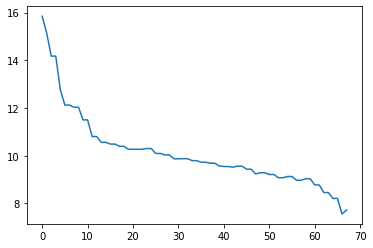

In [18]:
plt.plot(np.log(np.abs(res[0])))

In [33]:
fOpt(True, maxIter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

<AxesSubplot:>

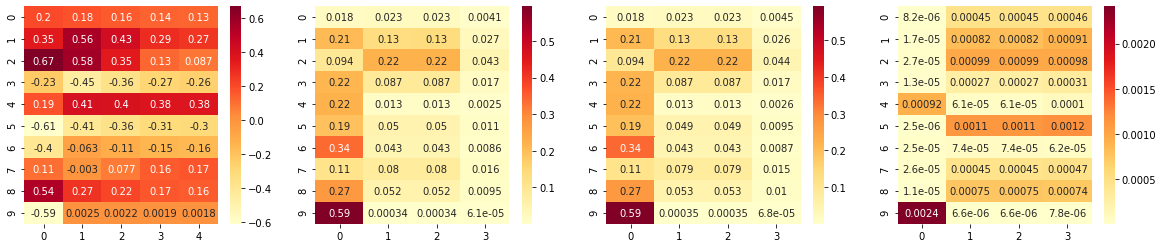

In [26]:
plt.figure(figsize=[20, 4])

plt.subplot(141)
matNp = fOpt.paraMu.cpu().numpy()
sns.heatmap(matNp, cmap="YlOrRd",  annot=True)

plt.subplot(142)
thetaMat = torch.diff(fOpt.paraMu)
matNp1 = thetaMat.abs().cpu().numpy()
sns.heatmap(matNp1, cmap="YlOrRd",  annot=True)

plt.subplot(143)
matNp2 = colStackFn(fOpt.lastOptMu.lastTheta, fOpt.R2).abs().cpu().numpy()
sns.heatmap(matNp2, cmap="YlOrRd",  annot=True)

plt.subplot(144)
matNp = (colStackFn(fOpt.lastOptMu.lastTheta, fOpt.R2) - thetaMat).abs().cpu().numpy()
sns.heatmap(matNp, cmap="YlOrRd",  annot=True)

In [29]:
stdMus[:, :2]

array([[0.65465367+0.j        , 0.65465367+0.j        ],
       [0.4472136 +0.j        , 0.4472136 +0.j        ],
       [0.36860489+0.29488391j, 0.36860489+0.29488391j],
       [0.36860489-0.29488391j, 0.36860489-0.29488391j],
       [0.33028913+0.16514456j, 0.33028913+0.16514456j],
       [0.33028913-0.16514456j, 0.33028913-0.16514456j]])

In [63]:
fOpt.kpidx

array([0, 2, 3, 4, 5])

In [95]:
torch.cat([torch.rand(10), torch.rand(4)])

tensor([0.1942, 0.4055, 0.4960, 0.9274, 0.9040, 0.4930, 0.8401, 0.0426, 0.5629,
        0.2781, 0.5297, 0.9016, 0.3365, 0.4707])